In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

df = pd.read_excel('DryBeanDataSet.xlsx')
df

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,Constantness,EquivDiameter,Colour,...,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,ShapeFactor5,ShapeFactor6,Class,Sort order
0,84648,1132.054,439.915710,248.961941,1.767000,0.824453,86779,1,328.294351,brown,...,0.830027,0.746266,0.005197,0.000994,0.556914,3.487008,0.984066,50.809833,CALI,0.134791
1,39704,736.873,271.659919,186.481404,1.456767,0.727175,40106,1,224.839282,black,...,0.918880,0.82765,0.006842,0.001980,0.685004,1.242335,0.997891,148.508874,DERMASON,0.898848
2,35835,687.914,237.704180,192.176759,1.236904,0.588537,36190,1,213.603696,green,...,0.951588,0.898611,0.006633,0.002668,0.807503,2.813489,0.998803,82.107117,SEKER,0.539684
3,223035,1817.278,680.812555,419.994347,1.621004,0.787040,225889,1,532.894907,brown,...,0.848673,0.782734,0.003052,0.000707,0.612672,3.074472,0.993144,147.347735,BOMBAY,0.149130
4,41957,767.143,287.962974,186.166695,1.546802,0.762918,42310,1,231.130508,brown,...,0.895904,0.80264,0.006863,0.001757,0.644230,2.213954,0.996497,22.893826,SIRA,0.447635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,23018,578.382,203.761000,144.297607,1.412089,0.706041,23465,1,171.194123,black,...,0.864665,0.840171,0.008852,0.002721,0.705888,2.197446,0.996776,85.821969,DERMASON,0.764478
13607,69773,1095.057,387.116310,231.153291,1.674717,0.802155,71055,1,298.056610,brown,...,0.731179,0.769941,0.005548,0.001203,0.592809,1.004792,0.992787,152.980591,BARBUNYA,0.679735
13608,55773,968.988,347.920243,204.491191,1.701395,0.809040,57047,0,266.481499,brown,...,0.746444,0.765927,0.006238,0.001324,0.586644,2.219590,0.998113,102.437378,BARBUNYA,0.946849
13609,64235,1005.875,409.304636,201.686606,2.029409,0.870169,65018,1,285.983465,white,...,0.797799,0.698706,0.006372,0.000937,0.488190,2.078504,0.990736,174.754039,HOROZ,0.046135


In [17]:
# Here let's check for missing values.
df.replace('?',pd.NA ,inplace=True)
missingvalues = df.isna().sum()

# Our problem columns that are not numeric are Extent, compactness and Shape factor 6
df['Extent'] = pd.to_numeric(df['Extent'], errors='coerce')
df['Compactness'] = pd.to_numeric(df['Compactness'], errors='coerce')
df['ShapeFactor6'] = pd.to_numeric(df['ShapeFactor6'], errors='coerce')

numerical_cols = df.select_dtypes(include=['float', 'int']).columns

## Feature Selection

In [18]:
df_fs = df.copy()
df_fs = df_fs.drop(['Sort order'], axis=1)

# Before preforming feature selection we first need to impute missing values and invalid outliers.
# We impute categorical with mode.
mode_colour = df_fs['Colour'].mode().iloc[0]
df_fs['Colour'] = df_fs['Colour'].fillna(mode_colour)
# Numerical values we will use the median since there are still outliers that the DT should be robust to. (Not extra data corrections)
for feature in ['Extent', 'Compactness', 'ShapeFactor6']:
    median_value = df_fs[feature].median()
    df_fs[feature] = df_fs[feature].fillna(median_value)

df_fs = df_fs.dropna(subset=['Class'])

In [19]:
# Now lets deal with extreme outliers.
def detect_outliers(df, features, threshold=3):
    outliers = {}
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
    return outliers

def remove_outliers(df, outliers):
    df_copy = df.copy()
    all_outlier_indices = set()
    for _, indices in outliers.items():
        all_outlier_indices.update(indices)

    # Only remove indices that exist in the DataFrame
    indices_to_remove = all_outlier_indices.intersection(set(df_copy.index))

    if indices_to_remove:
        df_copy = df_copy.drop(indices_to_remove)
        print(f"Removed {len(indices_to_remove)} outliers")
    else:
        print("No outliers removed")

    return df_copy


features_to_analyze = [
    'Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation',
    'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity',
    'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3',
    'ShapeFactor4', 'ShapeFactor5', 'ShapeFactor6'
]

excluded_features = ['Constantness', 'Class', 'Sort order', 'Colour']

features_to_analyze = [f for f in features_to_analyze if f in df_fs.columns and f not in excluded_features]

outliers = detect_outliers(df_fs, features_to_analyze, threshold=3)
df_fs = remove_outliers(df_fs, outliers)

Removed 833 outliers


In [20]:
# Now we should be ready to perform feature selection.

X = df_fs.drop(['Class', 'Colour'], axis=1)
color = df_fs['Colour'].values.reshape(-1, 1)

onehot = OneHotEncoder(handle_unknown='ignore')
color_encoded = onehot.fit_transform(color)

color_columns = [f'Colour_{cat}' for cat in onehot.categories_[0]]
color_encoded_dense = color_encoded.toarray()

X = X.reset_index(drop=True)
color_df = pd.DataFrame(color_encoded_dense, columns=color_columns)

X = pd.concat([X, color_df], axis=1)
y = df_fs['Class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 1. Univariate Selection (ANOVA F-value)
k_best_anova = SelectKBest(score_func=f_classif, k='all')
X_anova = k_best_anova.fit_transform(X, y_encoded)
anova_scores = pd.DataFrame({'Feature': X.columns, 'Score_ANOVA': k_best_anova.scores_})
anova_scores = anova_scores.sort_values('Score_ANOVA', ascending=False)

# 2. Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y_encoded)
rf_scores = pd.DataFrame({'Feature': X.columns, 'Score_RF': rf.feature_importances_})
rf_scores = rf_scores.sort_values('Score_RF', ascending=False)


print("Top 23 features (ANOVA F-value):")
print(anova_scores.head(23))
print("\nTop 23 features (Random Forest Importance):")
print(rf_scores.head(23))

combined_scores = anova_scores.merge(rf_scores, on='Feature')
combined_scores['Average_Score'] = combined_scores[['Score_ANOVA', 'Score_RF']].mean(axis=1)
combined_scores = combined_scores.sort_values('Average_Score', ascending=False)

print("\nTop 23 features (Combined Average Score):")
print(combined_scores[['Feature', 'Average_Score']].head(23))

Top 23 features (ANOVA F-value):
            Feature   Score_ANOVA
19     Colour_black  5.416873e+06
22     Colour_white  3.272450e+06
21     Colour_green  1.768753e+06
20     Colour_brown  1.660876e+06
2   MajorAxisLength  1.328200e+04
1         Perimeter  1.314008e+04
8     EquivDiameter  1.175125e+04
6        ConvexArea  1.162380e+04
0              Area  1.151755e+04
14     ShapeFactor2  1.048206e+04
4      AspectRation  1.046846e+04
12      Compactness  9.858497e+03
15     ShapeFactor3  9.772941e+03
3   MinorAxisLength  8.802305e+03
5      Eccentricity  8.403677e+03
13     ShapeFactor1  7.405235e+03
11        roundness  6.812741e+03
17     ShapeFactor5  1.684945e+03
10         Solidity  9.265702e+02
9            Extent  3.664619e+02
16     ShapeFactor4  1.072002e+01
7      Constantness  1.605467e+00
18     ShapeFactor6  1.021285e+00

Top 23 features (Random Forest Importance):
            Feature  Score_RF
20     Colour_brown  0.117440
19     Colour_black  0.117323
21     Colour_gr

## K-NN Implementation

In [21]:
df_knn = df.copy()

# Remove rows with NA in the target variable
df_knn = df_knn.dropna(subset=['Class'])

# Handle missing values in the 'Colour' feature
df_knn['Colour'] = df_knn['Colour'].fillna('Unknown')

# Separate features and target
X = df_knn.drop(['Class', 'Sort order','ShapeFactor6','Constantness','ShapeFactor4'], axis=1)
y = df_knn['Class']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

In [22]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5, weights='distance'))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf.fit(X_train, y_train)

# Evaluate the model
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print(f"Training accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=10)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Training accuracy: 1.0000
Test accuracy: 0.9863
Cross-validation scores: [0.98235294 0.9875     0.98823529 0.98161765 0.98822664 0.97939662
 0.98454746 0.98160412 0.98086829 0.9874908 ]
Mean CV accuracy: 0.9842 (+/- 0.0065)


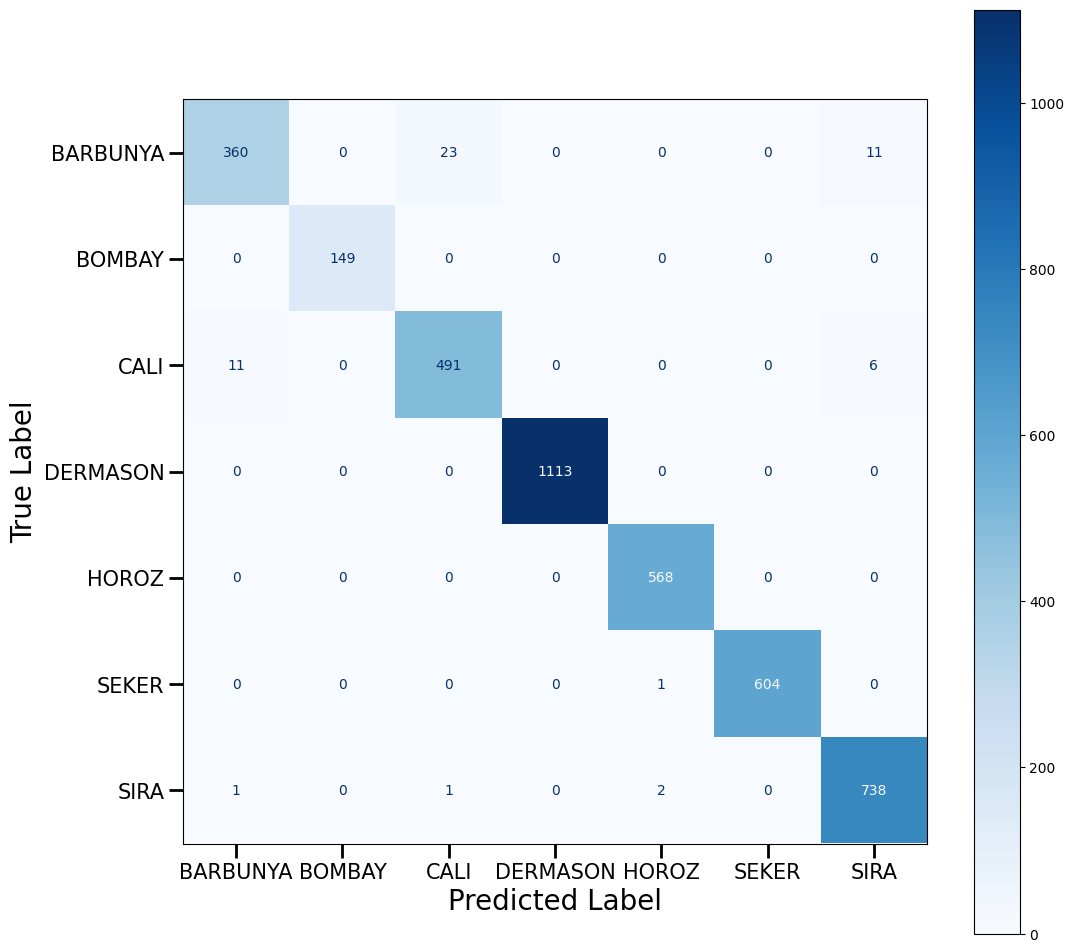


Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.97      0.91      0.94       394
      BOMBAY       1.00      1.00      1.00       149
        CALI       0.95      0.97      0.96       508
    DERMASON       1.00      1.00      1.00      1113
       HOROZ       0.99      1.00      1.00       568
       SEKER       1.00      1.00      1.00       605
        SIRA       0.98      0.99      0.99       742

    accuracy                           0.99      4079
   macro avg       0.98      0.98      0.98      4079
weighted avg       0.99      0.99      0.99      4079



In [23]:
y_pred = clf.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15, length=10, width=2)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

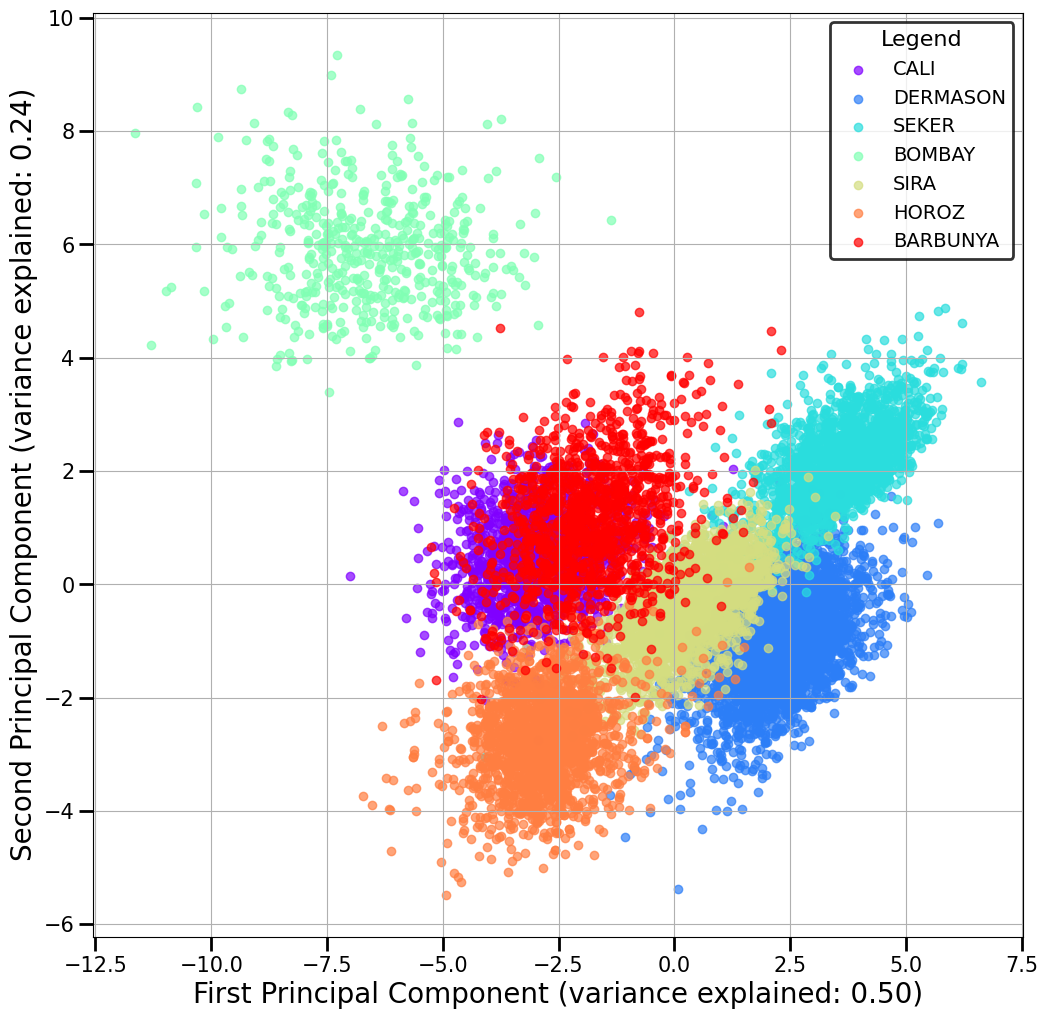

In [24]:
X_preprocessed = preprocessor.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y.values

# Plot
plt.figure(figsize=(12, 12))
classes = pca_df['Class'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))

for class_name, color in zip(classes, colors):
    mask = pca_df['Class'] == class_name
    plt.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'],
                c=[color], label=class_name, alpha=0.7)

plt.xlabel(f'First Principal Component (variance explained: {pca.explained_variance_ratio_[0]:.2f})',fontsize=20)
plt.ylabel(f'Second Principal Component (variance explained: {pca.explained_variance_ratio_[1]:.2f})', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15, length=10, width=2)
legend = plt.legend(fontsize=14, title='Legend', title_fontsize=16)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('black')
plt.grid(True)
plt.show()

## Decision Tree Implementation

Tree Depth: 10
Number of Leaves: 61
Cross-validation Score: 0.9821

Classification Report:
              precision    recall  f1-score   support

    BARBUNYA       0.92      0.90      0.91       384
      BOMBAY       1.00      0.99      1.00       170
        CALI       0.93      0.95      0.94       511
    DERMASON       1.00      1.00      1.00      1089
       HOROZ       1.00      1.00      1.00       593
       SEKER       1.00      1.00      1.00       571
        SIRA       0.99      0.99      0.99       761

    accuracy                           0.98      4079
   macro avg       0.98      0.97      0.97      4079
weighted avg       0.98      0.98      0.98      4079



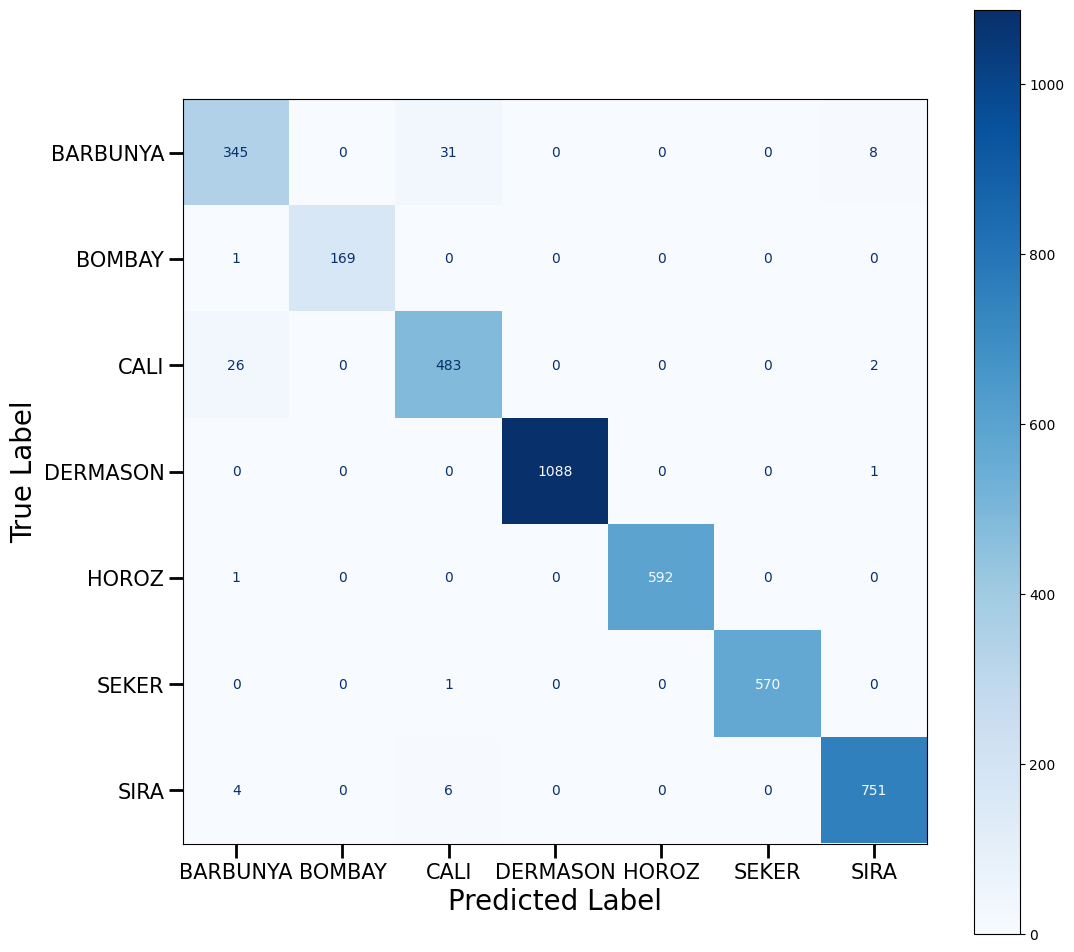

In [25]:
df_ds = df.copy()
df_ds = df_ds.dropna(subset=['Class'])

df_ds['Colour'] = df_ds['Colour'].fillna('brown')

X = df_ds.drop(['Class','Sort order','ShapeFactor6','ShapeFactor4','Constantness'], axis=1)
y = df_ds['Class']

categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_columns)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

cv_score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5).mean()

print(f"Tree Depth: {clf.get_depth()}")
print(f"Number of Leaves: {clf.get_n_leaves()}")
print(f"Cross-validation Score: {cv_score:.4f}")

y_pred = clf.predict(X_test_preprocessed)

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Print the full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15, length=10, width=2)
plt.show()